In [1]:
### Reference : https://github.com/lukemelas/EfficientNet-PyTorch
# Tested EfficientNet architecture which is smaller than baseline Efficient-B0 model

### Utils

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

import re
import math
import collections
from functools import partial


######################
### Utils for model
#######################

# Parameters for the entire model
GlobalParams = collections.namedtuple('GlobalParams', [
    'width_multiplier', 'depth_multiplier', 'image_size', 'dropout_rate',
    'num_classes', 'batch_norm_momentum', 'batch_norm_epsilon',
    'drop_connect_rate', 'depth_divisor', 'min_depth', 'include_top'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'num_repeat', 'kernel_size', 'stride', 'expand_ratio',
    'input_filters', 'output_filters', 'se_ratio', 'id_skip'])

# Set GlobalParams and BlockArgs's defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


# Implementation of Swish function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# A memory-efficient implementation of Swish function
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)


# Calculate and round number of filters based on width multiplier and min_depth
def round_filters(filters, global_params):
    multiplier = global_params.width_multiplier
    if not multiplier:
        return filters

    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor # pay attention to this line when using min_depth
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters: # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)

# Calculate module's repeat number of a block based on depth multiplier
def round_repeats(repeats, global_params):
    multiplier = global_params.depth_multiplier
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))

def drop_connect(inputs, p, training):
    """Drop connect.
    Args:
        input (tensor: [B(Batch dimension),C(Channel dimension),W,H]): Input of this structure.
        p : Probability of drop connection.
        training (bool): The running mode.
    Returns:
        output: Output after drop connection.
    """
    assert p >= 0 and p <= 1, 'p must be in range of [0,1]'

    if not training:
        return inputs

    batch_size = inputs.shape[0]
    keep_prob = 1 - p

    # generate binary_tensor mask according to probability (p for 0, 1-p for 1)
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)

    output = inputs / keep_prob * binary_tensor
    return output

# Obtain height and width from x where x is tuple or list (H,W)
def get_width_and_height_from_size(x):
    if isinstance(x, int):
        return x, x
    if isinstance(x, list) or isinstance(x, tuple):
        return x
    else:
        raise TypeError()


def calculate_output_image_size(input_image_size, stride):
    """Calculates the output image size when using Conv2dSamePadding with a stride.
       Necessary for static padding. Thanks to mannatsingh for pointing this out.
    Args:
        input_image_size (tuple or list): Size of input image.
        stride (int, tuple or list): Conv2d operation's stride.
    Returns:
        output_image_size: A list [H,W].
    """
    if input_image_size is None:
        return None
    image_height, image_width = get_width_and_height_from_size(input_image_size)
    stride = stride if isinstance(stride, int) else stride[0]
    image_height = int(math.ceil(image_height / stride))
    image_width = int(math.ceil(image_width / stride))
    return [image_height, image_width]


# Same padding option of Conv2D of Tensorflow : preserve output size as input size
# Implemented 2D Convolutions with same padding option like TensorFlow for a dynamic image size
class Conv2dDynamicSamePadding(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw) # change the output size according to stride ! ! !
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x

def get_same_padding_conv2d(image_size=None):
    """Chooses static padding if you have specified an image size, and dynamic padding otherwise.
       Static padding is necessary for ONNX exporting of models.
    Args:
        image_size (int or tuple): Size of the image.
    Returns:
        Conv2dDynamicSamePadding or Conv2dStaticSamePadding.
    """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


# Similar as above, implemented max pooling with same padding option
class MaxPool2dDynamicSamePadding(nn.MaxPool2d):
    def __init__(self, kernel_size, stride, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super().__init__(kernel_size, stride, padding, dilation, return_indices, ceil_mode)
        self.stride = [self.stride] * 2 if isinstance(self.stride, int) else self.stride
        self.kernel_size = [self.kernel_size] * 2 if isinstance(self.kernel_size, int) else self.kernel_size
        self.dilation = [self.dilation] * 2 if isinstance(self.dilation, int) else self.dilation

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.kernel_size
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding,
                            self.dilation, self.ceil_mode, self.return_indices)

class MaxPool2dStaticSamePadding(nn.MaxPool2d):
    def __init__(self, kernel_size, stride, image_size=None, **kwargs):
        super().__init__(kernel_size, stride, **kwargs)
        self.stride = [self.stride] * 2 if isinstance(self.stride, int) else self.stride
        self.kernel_size = [self.kernel_size] * 2 if isinstance(self.kernel_size, int) else self.kernel_size
        self.dilation = [self.dilation] * 2 if isinstance(self.dilation, int) else self.dilation

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.kernel_size
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.max_pool2d(x, self.kernel_size, self.stride, self.padding,
                         self.dilation, self.ceil_mode, self.return_indices)
        return x

def get_same_padding_maxPool2d(image_size=None):
    """Chooses static padding if you have specified an image size, and dynamic padding otherwise.
       Static padding is necessary for ONNX exporting of models.
    Args:
        image_size (int or tuple): Size of the image.
    Returns:
        MaxPool2dDynamicSamePadding or MaxPool2dStaticSamePadding.
    """
    if image_size is None:
        return MaxPool2dDynamicSamePadding
    else:
        return partial(MaxPool2dStaticSamePadding, image_size=image_size)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


###############################################
### Helper functions for loading model params
###############################################

# Block Decoder for readability
class BlockDecoder(object):
    @staticmethod
    def _decode_block_string(block_string):
        """Get a block through a string notation of arguments.
        Args:
            block_string (str): A string notation of arguments.
                                Examples: 'r1_k3_s11_e1_i32_o16_se0.25_noskip'.
        Returns:
            BlockArgs: The namedtuple defined at the top of this file.
        """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            num_repeat=int(options['r']),
            kernel_size=int(options['k']),
            stride=[int(options['s'][0])],
            expand_ratio=int(options['e']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            se_ratio=float(options['se']) if 'se' in options else None,
            id_skip=('noskip' not in block_string))

    @staticmethod
    def _encode_block_string(block):
        """Encode a block to a string.
        Args:
            block (namedtuple): A BlockArgs type argument.
        Returns:
            block_string: A String form of BlockArgs.
        """
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """Decode a list of string notations to specify blocks inside the network.
        Args:
            string_list (list[str]): A list of strings, each string is a notation of block.
        Returns:
            blocks_args: A list of BlockArgs namedtuples of block args.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """Encode a list of BlockArgs to a list of strings.
        Args:
            blocks_args (list[namedtuples]): A list of BlockArgs namedtuples of block args.
        Returns:
            block_strings: A list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


# Map EfficientNet model name to parameter coefficients
# With input="Model name", returns (width,depth,res,dropout) tuple
def efficientnet_params(model_name):
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]

# Create BlockArgs and GlobalParams for efficientnet model
def efficientnet(width_coefficient=None, depth_coefficient=None, image_size=None,
                 dropout_rate=0.2, drop_connect_rate=0.2, num_classes=1000):
    """Create BlockArgs and GlobalParams for efficientnet model.
    Args:
        width_coefficient (float)
        depth_coefficient (float)
        image_size (int)
        dropout_rate (float)
        drop_connect_rate (float)
        num_classes (int)
        Meaning as the name suggests.
    Returns:
        blocks_args, global_params.
    """
    # Blocks args for efficientnet-b0 by default
    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25',
        'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25',
        'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25',
        'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        width_multiplier=width_coefficient,
        depth_multiplier=depth_coefficient,
        image_size=image_size,
        dropout_rate=dropout_rate,

        num_classes=num_classes,
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        drop_connect_rate=drop_connect_rate,
        depth_divisor=8,
        min_depth=None,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """Get the block args and global params for a given model name.
    Args:
        model_name (str): Model's name.
        override_params (dict): A dict to modify global_params.
    Returns:
        blocks_args, global_params
    """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


# train with Standard methods
# check more details in paper(EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks)
url_map = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',
}


# load_pretrained_weights: A function to load pretrained weights
def load_pretrained_weights(model, model_name, weights_path=None, load_fc=True):
    """Loads pretrained weights from weights path or download using url.
    Args:
        model (Module): The whole model of efficientnet.
        model_name (str): Model name of efficientnet.
        weights_path (None or str): 
            str: path to pretrained weights file on the local disk.
            None: use pretrained weights downloaded from the Internet.
        load_fc (bool): Whether to load pretrained weights for fc layer at the end of the model.
    """
    if isinstance(weights_path,str):
        state_dict = torch.load(weights_path)
    else:
        # AutoAugment or Advprop (different preprocessing)
        url_map_ = url_map
        state_dict = model_zoo.load_url(url_map_[model_name])
    
    if load_fc:
        ret = model.load_state_dict(state_dict, strict=False)
        assert not ret.missing_keys, f'Missing keys when loading pretrained weights: {ret.missing_keys}'
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        ret = model.load_state_dict(state_dict, strict=False)
        assert set(ret.missing_keys) == set(
            ['_fc.weight', '_fc.bias']), f'Missing keys when loading pretrained weights: {ret.missing_keys}'
    assert not ret.unexpected_keys, f'Missing keys when loading pretrained weights: {ret.unexpected_keys}'

    print('Loaded pretrained weights for {}'.format(model_name))

### Model Architecture

In [3]:
#############################################
###  Model and module class for EfficientNet
#############################################


import torch
from torch import nn
from torch.nn import functional as F

VALID_MODELS = (
    'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3',
    'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7',
    'efficientnet-b8', 'efficientnet-l2'
)


# Mobile Inverted Residual Bottleneck Block
class MBConvBlock(nn.Module):
    """Args:
        block_args (namedtuple): BlockArg
        global_params (namedtuple): GlobalParam
        image_size (tuple or list): [image_height, image_width].
    """

    def __init__(self, block_args, global_params, image_size=None):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum  # pytorch's difference from tensorflow
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # whether to use skip connection and drop connect

        # Expansion phase (Inverted Bottleneck)
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            Conv2d = get_same_padding_conv2d(image_size=image_size)
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
        image_size = calculate_output_image_size(image_size, s)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            Conv2d = get_same_padding_conv2d(image_size=(1, 1))
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Pointwise convolution phase
        final_oup = self._block_args.output_filters
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """MBConvBlock's forward function.
        Args:
            inputs (tensor): Input tensor.
            drop_connect_rate (bool): Drop connect rate (float, between 0 and 1).
        Returns:
            Output of this block after processing.
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._expand_conv(inputs)
            x = self._bn0(x)
            x = self._swish(x)

        x = self._depthwise_conv(x)
        x = self._bn1(x)
        x = self._swish(x)

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_reduce(x_squeezed)
            x_squeezed = self._swish(x_squeezed)
            x_squeezed = self._se_expand(x_squeezed)
            x = torch.sigmoid(x_squeezed) * x

        # Pointwise Convolution
        x = self._project_conv(x)
        x = self._bn2(x)

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            # The combination of skip connection and drop connect brings about stochastic depth.
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).
        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()



class EfficientNet(nn.Module):
    """EfficientNet model.
       Most easily loaded with the .from_name or .from_pretrained methods.
    Args:
        blocks_args (list[namedtuple]): A list of BlockArgs to construct blocks.
        global_params (namedtuple): A set of GlobalParams shared between blocks.
    Example:
        >>> import torch
        >>> from efficientnet.model import EfficientNet
        >>> inputs = torch.rand(1, 3, 224, 224)
        >>> model = EfficientNet.from_pretrained('efficientnet-b0')
        >>> model.eval()
        >>> outputs = model(inputs)
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Get stem static or dynamic convolution depending on image size
        image_size = global_params.image_size
        Conv2d = get_same_padding_conv2d(image_size=image_size)

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        image_size = calculate_output_image_size(image_size, 2)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
            image_size = calculate_output_image_size(image_size, block_args.stride)
            if block_args.num_repeat > 1:  # modify block_args to keep same output size
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
                # image_size = calculate_output_image_size(image_size, block_args.stride)  # stride = 1

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        if self._global_params.include_top:
            self._dropout = nn.Dropout(self._global_params.dropout_rate)
            self._fc = nn.Linear(out_channels, self._global_params.num_classes)

        # set activation to memory efficient swish by default
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).
        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_endpoints(self, inputs):
        """Use convolution layer to extract features
        from reduction levels i in [1, 2, 3, 4, 5].
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Dictionary of last intermediate features
            with reduction levels i in [1, 2, 3, 4, 5].
            Example:
                >>> import torch
                >>> from efficientnet.model import EfficientNet
                >>> inputs = torch.rand(1, 3, 224, 224)
                >>> model = EfficientNet.from_pretrained('efficientnet-b0')
                >>> endpoints = model.extract_endpoints(inputs)
                >>> print(endpoints['reduction_1'].shape)  # torch.Size([1, 16, 112, 112])
                >>> print(endpoints['reduction_2'].shape)  # torch.Size([1, 24, 56, 56])
                >>> print(endpoints['reduction_3'].shape)  # torch.Size([1, 40, 28, 28])
                >>> print(endpoints['reduction_4'].shape)  # torch.Size([1, 112, 14, 14])
                >>> print(endpoints['reduction_5'].shape)  # torch.Size([1, 320, 7, 7])
                >>> print(endpoints['reduction_6'].shape)  # torch.Size([1, 1280, 7, 7])
        """
        endpoints = dict()

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        prev_x = x

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
            if prev_x.size(2) > x.size(2):
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = prev_x
            elif idx == len(self._blocks) - 1:
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = x
            prev_x = x

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))
        endpoints['reduction_{}'.format(len(endpoints) + 1)] = x

        return endpoints

    # Output of the final convolution layer
    def extract_features(self, inputs):
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        # Convolution layers
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, in_channels=3, **override_params):
        """Create an efficientnet model according to name.
        Args:
            model_name (str): Name for efficientnet.
            in_channels (int): Input data's channel number.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'num_classes', 'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'
        Returns:
            An efficientnet model.
        """
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        model = cls(blocks_args, global_params)
        model._change_in_channels(in_channels)
        return model

    @classmethod
    def from_pretrained(cls, model_name, weights_path=None, advprop=False,
                        in_channels=3, num_classes=1000, **override_params):
        """Create an efficientnet model according to name.
        Args:
            model_name (str): Name for efficientnet.
            weights_path (None or str):
                str: path to pretrained weights file on the local disk.
                None: use pretrained weights downloaded from the Internet.
            advprop (bool):
                Whether to load pretrained weights
                trained with advprop (valid when weights_path is None).
            in_channels (int): Input data's channel number.
            num_classes (int):
                Number of categories for classification.
                It controls the output size for final linear layer.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'
        Returns:
            A pretrained efficientnet model.
        """
        model = cls.from_name(model_name, num_classes=num_classes, **override_params)
        load_pretrained_weights(model, model_name, weights_path=weights_path,
                                load_fc=(num_classes == 1000))
        model._change_in_channels(in_channels)
        return model

    # Get the input image size for a given efficientnet model
    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    # Check whether model name is valid
    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        if model_name not in VALID_MODELS:
            raise ValueError('model_name should be one of: ' + ', '.join(VALID_MODELS))

    def _change_in_channels(self, in_channels):
        """Adjust model's first convolution layer to in_channels, if in_channels not equals 3.
        Args:
            in_channels (int): Input data's channel number.
        """
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size=self._global_params.image_size)
            out_channels = round_filters(32, self._global_params)
            self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)

### Load examplary Data : CIFAR100 

Files already downloaded and verified
Total number of train_set is 45000 among total 50000 data
Files already downloaded and verified
Input image is 64x64 size with 3 channels


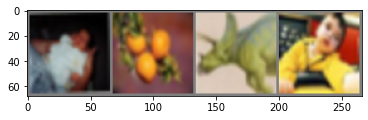

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_val_ratio = 0.9
num_train = int(len(trainset)*train_val_ratio)
train_set, val_set = torch.utils.data.random_split(trainset, [num_train, len(trainset)-num_train])
print(f"Total number of train_set is {num_train} among total {len(trainset)} data")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

images, labels = next(iter(train_loader))
print(f"Input image is {images.size()[-2]}x{images.size()[-1]} size with {images.size()[-3]} channels")

# show images
imshow(torchvision.utils.make_grid(images[:4]))

### Test & Train

In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim


class Trainer(object):
    def __init__(self, model, cuda, optim=None, train_loader=None, val_loader=None, test_loader=None):
        self.loss_ftn = nn.CrossEntropyLoss()
        self.cuda = cuda
        self.model = model
        self.optim = optim
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def test_acc(self, cmd=None):
        if cmd == 'val':
            data_loader = self.val_loader
        else:
            data_loader = self.test_loader

        correct, total = 0, 0
        self.model.eval()
        with torch.no_grad():
            for _, (images, labels) in enumerate(data_loader):
                if self.cuda:
                    images = images.cuda()
                    labels = labels.cuda()

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total


    def train(self, n_epoch):
        for i in tqdm(range(n_epoch)):
            self.model.train()
            train_loss = 0
            correct, total = 0, 0
            for _, (images, labels) in enumerate(self.train_loader):
                # If gpu is available, add data to cuda
                if self.cuda:
                    images = images.cuda()
                    labels = labels.cuda()

                self.optim.zero_grad()
                outputs = self.model(images)
                loss = self.loss_ftn(outputs, labels)
                loss.backward()
                self.optim.step()
                train_loss += loss.item()

                # Caculate train accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            val_acc = self.test_acc(cmd='val')
            print('===> Epoch: {} / Avg train loss: {:.4f} / Train acc: {:.2f}% / Val acc: {:.2f}%'.format(i, 
                        train_loss / len(train_loader.dataset), 100 * correct / total, val_acc))


cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# According to EfficientNet scale factor, scaled down baseline efficientnet-B0 
model = EfficientNet.from_name('efficientnet-b0', width_multiplier=(1/1.6)**2, depth_multiplier=(1/2.2)**2, 
                               image_size=[64,64], num_classes=100, include_top=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, 
                                                steps_per_epoch=5, epochs=50)
trainer = Trainer(model=model, cuda=cuda, optim=optimizer, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

# Check number of parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters : {pytorch_total_params}")

trainer.train(n_epoch=50)
print(f'Test accuracy : {trainer.test_acc()}%')

Number of model parameters : 302598


  0%|          | 0/50 [00:00<?, ?it/s]

===> Epoch: 0 / Avg train loss: 0.0598 / Train acc: 10.17% / Val acc: 11.18%
===> Epoch: 1 / Avg train loss: 0.0516 / Train acc: 18.39% / Val acc: 18.26%
===> Epoch: 2 / Avg train loss: 0.0467 / Train acc: 24.27% / Val acc: 24.72%
===> Epoch: 3 / Avg train loss: 0.0428 / Train acc: 29.09% / Val acc: 28.62%
===> Epoch: 4 / Avg train loss: 0.0399 / Train acc: 32.82% / Val acc: 29.62%
===> Epoch: 5 / Avg train loss: 0.0375 / Train acc: 35.78% / Val acc: 33.70%
===> Epoch: 6 / Avg train loss: 0.0355 / Train acc: 38.83% / Val acc: 36.52%
===> Epoch: 7 / Avg train loss: 0.0339 / Train acc: 40.82% / Val acc: 37.98%
===> Epoch: 8 / Avg train loss: 0.0325 / Train acc: 43.13% / Val acc: 36.12%
===> Epoch: 9 / Avg train loss: 0.0311 / Train acc: 44.86% / Val acc: 40.48%
===> Epoch: 10 / Avg train loss: 0.0301 / Train acc: 46.55% / Val acc: 39.72%
===> Epoch: 11 / Avg train loss: 0.0293 / Train acc: 47.92% / Val acc: 40.06%
===> Epoch: 12 / Avg train loss: 0.0282 / Train acc: 49.18% / Val acc: 40.